# Datashading a 1-billion-point Open Street Map database

The [osm.ipynb](https://anaconda.org/jbednar/osm) example shows how to use Dask's out of core support for working with datasets larger than will fit in memory.  Here, we consider the largest dataset that will fit comfortably on a 16GB machine, namely 1 billion x,y points (at 32-bit float resolution). You can download it from [our site](http://s3.amazonaws.com/datashader-data/osm-1billion.snappy.parq.zip) and unzip it into the `data/` subdirectory, but because of its size it's not downloaded with the other examples by default, and please try to limit the number of times you download it so that we can continue making it available.

The data is taken from Open Street Map's (OSM) [bulk GPS point data](https://blog.openstreetmap.org/2012/04/01/bulk-gps-point-data/). The data was collected by OSM contributors' GPS devices, and was provided as a CSV file of `latitude,longitude` coordinates. The data was downloaded from their website, extracted, converted to use positions in Web Mercator format using `datashader.utils.lnglat_to_meters()`, and then stored in a [parquet](https://github.com/dask/fastparquet) file for [faster disk access](https://github.com/bokeh/datashader/issues/129#issuecomment-300515690). As usual, loading it into memory will be the most time-consuming step, by far:
http://s3.amazonaws.com/datashader-data/census.snappy.parq.zip

In [1]:
import dask.dataframe as dd
import dask.diagnostics as diag
import dask.distributed as dist
import datashader as ds
import datashader.transfer_functions as tf

from functools import partial
from colorcet import fire
from datashader.utils import export_image
from datashader.colors import colormap_select

In [2]:
%%time
df = dd.io.parquet.read_parquet('data/osm-1billion.snappy.parq')
df = df.persist()

CPU times: user 5.03 s, sys: 15.3 s, total: 20.3 s
Wall time: 13 s


In [3]:
print(len(df))
df.head()

1000050363


,x,y
0,16076076.0,-3627207.25
1,16832806.0,-4007314.75
2,15767838.0,-4390363.00
3,19442192.0,-4364528.00
4,16130131.0,-4548868.50


### Aggregation

To visualize this data, we first create a canvas to provide pixel-shaped bins in which points can be aggregated, and then aggregate the data to produce a fixed-size aggregate array. For data already in memory, this aggregation is the only expensive step, because it requires reading every point in the dataset. For interactive use we are most interested in the performance for a *second* aggregation, after all of the components and data are in memory and the user is interacting with a plot dynamically.  So let's first do a dry run, which will be slightly slower, then do the full aggregation to show what performance can be expected during interactive use with a billion datapoints:

In [4]:
bound = 20026376.39
bounds = dict(x_range = (-bound, bound), y_range = (int(-bound*0.4), int(bound*0.6)))
plot_width = 900
plot_height = int(plot_width*0.5)

In [5]:
%%time
bounds2 = dict(x_range = (-bound/2, bound/2), y_range = (int(-bound*0.2), int(bound*0.3)))
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds2)
agg2=cvs.points(df, 'x', 'y', ds.count())

CPU times: user 5.7 s, sys: 7.91 s, total: 13.6 s
Wall time: 2.84 s


In [6]:
%%time
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds)
agg = cvs.points(df, 'x', 'y', ds.count())

CPU times: user 8.14 s, sys: 384 ms, total: 8.52 s
Wall time: 1.3 s


As you can see, once everything has been loaded, aggregating this billion-point dataset takes about a second on a 16GB Macbook laptop.  The remaining steps for display complete in milliseconds, so those times are not shown below.


### Transfer Function

To actually see the data, we need to render an image of the aggregate array.  Let's map small (but nonzero) counts to light blue, the largest counts to dark blue, and interpolate according to a logarithmic function in between:

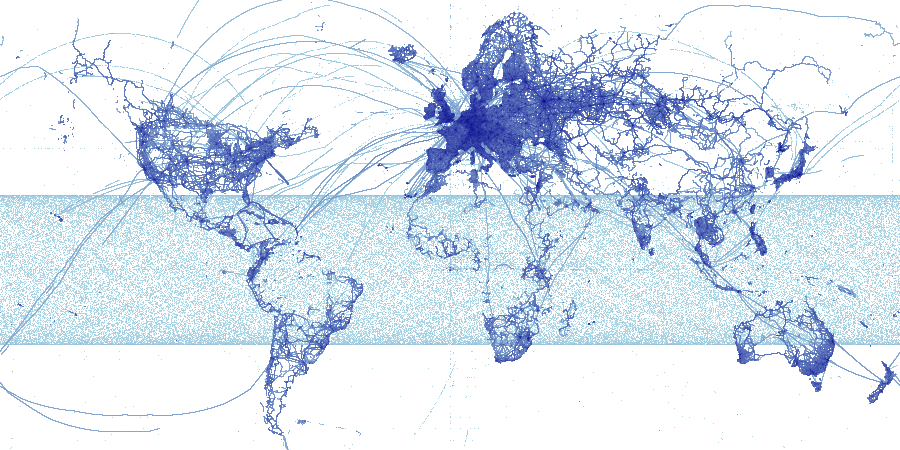

In [7]:
tf.shade(agg, cmap=["lightblue", "darkblue"], how='log')

There's some odd, low-count, nearly-uniform noise going on in the tropics. It's worth trying to figure out what that could be, but for now we can filter it out quickly from the aggregated data using the `where` method from xarray.  We'll also switch to the parameter-free histogram equalization method for mapping to colors using various colormaps:

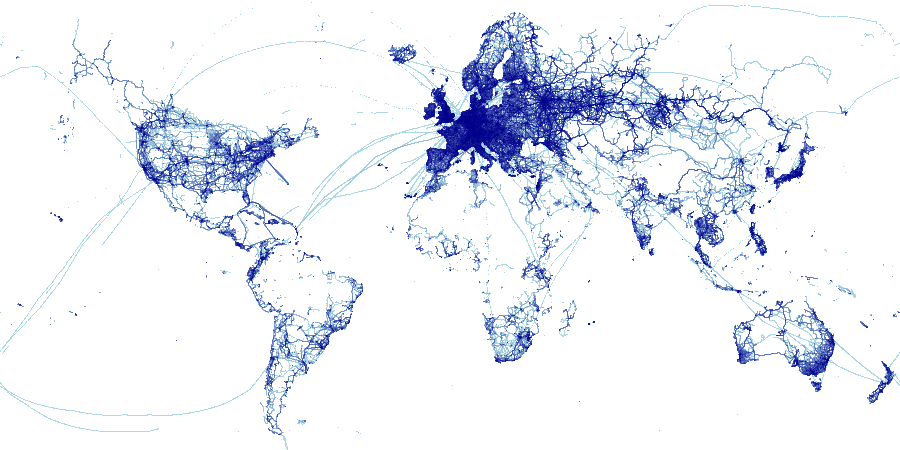

In [8]:
tf.shade(agg.where(agg > 15), cmap=["lightblue", "darkblue"])

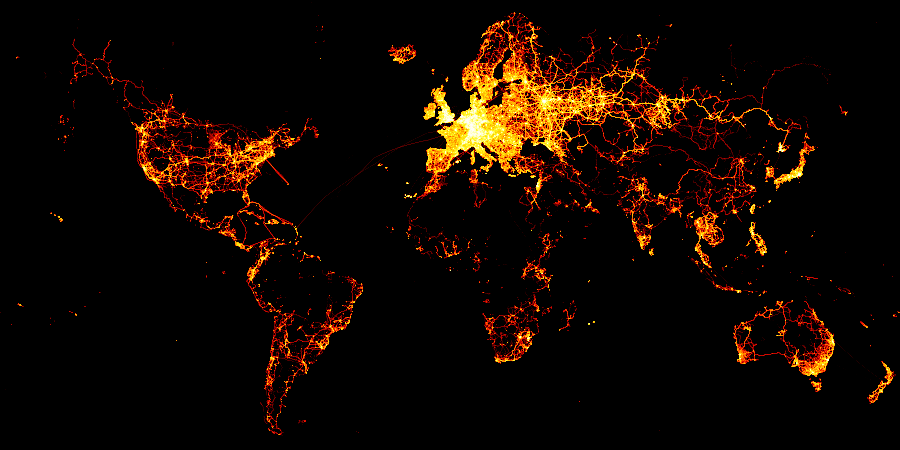

In [9]:
tf.set_background(tf.shade(agg.where(agg > 15), cmap=fire),"black")

The result covers the most-populated areas of the globe, with Europe apparently having particularly many OpenStreetMap contributors. The long great-circle paths visible on the white background are presumably flight or boat trips, from devices that log their GPS coordinates more than 15 times during the space of one pixel in this plot (or else they would have been eliminated by the `where` call).

### Interactive plotting

As long as the data fits into RAM on your machine, performance should be high enough to explore the data interactively, with only a brief pause after zooming or panning to a new region of the data space:

In [10]:
from bokeh.plotting import figure, output_notebook
from datashader.bokeh_ext import InteractiveImage
from datashader import transfer_functions as tf

output_notebook(hide_banner=True)

def create_image(x_range, y_range, w, h):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count())
    return tf.dynspread(tf.shade(agg, cmap=["darkblue", "lightcyan"]))

p = figure(tools='pan,wheel_zoom,box_zoom,reset', background_fill_color="black",
           plot_width=plot_width, plot_height=plot_height, **bounds)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
InteractiveImage(p, create_image)

Here the plot will be refreshed only if you are running the notebook with a live Python server; for static notebooks like those at anaconda.org you can zoom in but the plot will never be re-rendered at the higher resolution needed at that zoom level.